In [183]:
from google.cloud import bigquery
from functions import *
# Numpy & Pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import warnings
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Set the warning filter to ignore all warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)

from mlxtend.feature_selection import SequentialFeatureSelector as sfs
#import eli5
#from eli5.sklearn import PermutationImportance
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, QuantileTransformer, PowerTransformer, RobustScaler, MaxAbsScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
import xgboost as xgb
#import shap
from scipy.stats import chi2_contingency

In [184]:
# set display options to show all columns
pd.set_option('display.max_columns', None)
# Set the float format to display numbers without scientific notation
pd.options.display.float_format = '{:.2f}'.format
# Set the client for future queries to BigQuery
client = bigquery.Client(project = "continente-lced-feup")
#data_table.enable_dataframe_formatter()
#auth.authenticate_user()

In [185]:
!gcloud auth application-default login

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=764086051850-6qr4p6gpi6hn506pt8ejuq83di341hur.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8085%2F&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=8VIoKVhVBbpUbMTPf6FXhWMoiMoAS6&access_type=offline&code_challenge=S0l_kbHmMYH1gjW6oMdYXrpOUi1FN4X2m6enE2TZnsY&code_challenge_method=S256


Credentials saved to file: [/Users/vp/.config/gcloud/application_default_credentials.json]

These credentials will be used by any library that requests Application Default Credentials (ADC).

Quota project "continente-lced-feup" was added to ADC which can be used by Google client libraries for billing and quota. Note that some services may still bill the project owning the r

In [202]:
client = bigquery.Client(project = "continente-lced-feup")
query = client.query("""
   SELECT *
   FROM 
       tables_staging.df_bold_model
   """)

df = query.result().to_dataframe() # Wait for the job to complete.
df

,CUSTOMER_ACCOUNT_NR_MASK,SUBCAT_CD_EXT,MONTH,YEAR,QUARTER,SEMESTER,CUST_NUM_TRANSACTIONS_MONTH,CUST_NUM_TRANSACTIONS_QUARTER,CUST_NUM_TRANSACTIONS_SEMESTER,CUST_NUM_TRANSACTIONS_YEAR,CUST_TOTAL_QTY_BOUGHT_MONTH,CUST_TOTAL_QTY_BOUGHT_QUARTER,CUST_TOTAL_QTY_BOUGHT_SEMESTER,CUST_TOTAL_QTY_BOUGHT_YEAR,CUST_NUM_UNIQUE_SUBCAT_MONTH,CUST_NUM_UNIQUE_SUBCAT_QUARTER,CUST_NUM_UNIQUE_SUBCAT_SEMESTER,CUST_NUM_UNIQUE_SUBCAT_YEAR,CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH,CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_QUARTER,CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_SEMESTER,CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_YEAR,REG_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH,CUST_AVG_BASKET_SIZE_MONTH,CUST_AVG_BASKET_SIZE_QUARTER,CUST_AVG_BASKET_SIZE_SEMESTER,CUST_AVG_BASKET_SIZE_YEAR,SUBCAT_NUM_TRANSACTIONS_MONTH,SUBCAT_NUM_TRANSACTIONS_QUARTER,SUBCAT_NUM_TRANSACTIONS_SEMESTER,SUBCAT_NUM_TRANSACTIONS_YEAR,SUBCAT_TOTAL_QTY_BOUGHT_MONTH,SUBCAT_TOTAL_QTY_BOUGHT_QUARTER,SUBCAT_TOTAL_QTY_BOUGHT_SEMESTER,SUBCAT_TOTAL_QTY_BOUGHT_YEAR,SUBCAT_NUM_UNIQUE_CUST_MONTH,SUBCAT_NUM_UNIQUE_CUST_QUARTER,SUBCAT_NUM_UNIQUE_CUST_SEMESTER,SUBCAT_NUM_UNIQUE_CUST_YEAR,CUSTSUBCAT_NUM_TRANSACTIONS_MONTH,CUSTSUBCAT_NUM_TRANSACTIONS_QUARTER,CUSTSUBCAT_NUM_TRANSACTIONS_SEMESTER,CUSTSUBCAT_NUM_TRANSACTIONS_YEAR,CUSTSUBCAT_TOTAL_QTY_BOUGHT_MONTH,CUSTSUBCAT_TOTAL_QTY_BOUGHT_QUARTER,CUSTSUBCAT_TOTAL_QTY_BOUGHT_SEMESTER,CUSTSUBCAT_TOTAL_QTY_BOUGHT_YEAR,CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH,CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_QUARTER,CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_SEMESTER,CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_YEAR,GENDER,FAMILY_MEMBERS,SEG_LIFESTYLE_CD,SEG_LIFESTAGE_CD,CAT_CD_EXT,TARGET
0,9279821,100203,9,2021,3,2,3,17,17,44,54,231,231,790,27,53,53,71,5.50,5.06,5.06,6.14,1.00,13.00,10.76,10.76,14.52,164,528,528,1879,267,835,835,3055,136,373,373,928,0,0,0,0,0,0,0,0,0.00,0,0,0,F,"(3, 8)",3,5,1002,0
1,9298060,60402,9,2021,3,2,9,19,19,44,71,123,123,435,20,28,28,65,3.25,4.89,4.89,6.14,5.00,6.67,5.53,5.53,8.00,375,1065,1065,2973,501,1442,1442,3885,340,803,803,1585,2,3,3,4,2,3,3,4,0.00,23,23,39,F,"(3, 8)",1,5,604,0
2,11912555,70203,9,2021,3,2,8,16,16,44,68,210,210,803,27,55,55,85,2.14,4.60,4.60,5.84,13.50,6.25,9.56,9.56,12.89,357,1098,1098,3326,540,1712,1712,5156,297,719,719,1477,0,0,0,0,0,0,0,0,0.00,0,0,0,F,"(1, 2)",1,4,702,0
3,13337486,10202,9,2021,3,2,5,15,15,44,91,294,294,1079,38,57,57,77,4.00,5.64,5.64,5.95,5.00,10.60,12.47,12.47,14.07,676,2141,2141,6793,989,3124,3124,9940,577,1416,1416,2734,0,0,0,0,0,0,0,0,0.00,0,0,0,F,"(3, 8)",2,4,102,0
4,29461572,50401,9,2021,3,2,4,11,11,44,11,46,46,258,8,15,15,46,4.67,7.80,7.80,5.95,9.00,2.50,3.18,3.18,4.45,819,2497,2497,6937,1106,3368,3368,9454,560,1008,1008,1457,0,0,0,0,0,0,0,0,0.00,0,0,0,M,"(0, 0)",1,4,504,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3365383,87555786,140203,9,2022,3,2,3,13,13,43,33,142,142,465,18,33,33,51,9.50,7.08,7.08,5.71,5.00,8.67,8.08,8.08,8.19,80,259,259,672,196,671,671,1692,51,112,112,218,0,0,0,0,0,0,0,0,0.00,0,0,0,F,"(1, 2)",1,5,1402,0
3365384,295501,50305,9,2022,3,2,2,15,15,44,14,87,87,228,11,40,40,61,27.00,6.50,6.50,6.30,0.00,6.50,5.33,5.33,4.55,227,688,688,2106,310,1010,1010,3192,204,504,504,1037,0,0,0,0,0,0,0,0,0.00,0,0,0,F,"(3, 8)",2,4,503,0
3365385,1072151,90202,9,2022,3,2,3,12,12,44,54,243,243,904,29,52,52,78,3.50,6.45,6.45,5.56,0.00,15.00,16.75,16.75,16.73,781,2656,2656,7325,942,3361,3361,9157,713,1831,1831,3187,1,2,2,7,1,2,2,11,0.00,16,16,29,F,"(3, 8)",2,4,902,0
3365386,1072151,140202,9,2022,3,2,3,12,12,44,54,243,243,904,29,52,52,78,3.50,6.45,6.45,5.56,0.00,15.00,16.75,16.75,16.73,241,844,844,2421,515,1832,1832,5233,167,381,381,719,0,0,0,0,0,0,0,0,0.00,0,0,0,F,"(3, 8)",2,4,1402,0


# Data Preparation

In [203]:
df = df.dropna()
df = df.drop_duplicates()

df['fulldate'] = pd.to_datetime(df['MONTH'].astype(str) + '-' + df['YEAR'].astype(str))
# change from dtype datetime64[ns] to date time month
df['fulldate'] = df['fulldate'].dt.to_period('M')

df_200k = df.groupby('fulldate')#.apply(lambda x: x.drop(columns=['CUSTOMER_ACCOUNT_NR_MASK']))
df_200k = df.groupby('fulldate').sample(frac=1, random_state=101)

#drop customer id column because we want to generalize the model, instead of trying to predict for each customer
df_200k = df_200k.drop(columns=['CUSTOMER_ACCOUNT_NR_MASK'])

In [204]:
df_200k = df_200k[df_200k['SUBCAT_CD_EXT'] == 10101]
df_200k

,SUBCAT_CD_EXT,MONTH,YEAR,QUARTER,SEMESTER,CUST_NUM_TRANSACTIONS_MONTH,CUST_NUM_TRANSACTIONS_QUARTER,CUST_NUM_TRANSACTIONS_SEMESTER,CUST_NUM_TRANSACTIONS_YEAR,CUST_TOTAL_QTY_BOUGHT_MONTH,CUST_TOTAL_QTY_BOUGHT_QUARTER,CUST_TOTAL_QTY_BOUGHT_SEMESTER,CUST_TOTAL_QTY_BOUGHT_YEAR,CUST_NUM_UNIQUE_SUBCAT_MONTH,CUST_NUM_UNIQUE_SUBCAT_QUARTER,CUST_NUM_UNIQUE_SUBCAT_SEMESTER,CUST_NUM_UNIQUE_SUBCAT_YEAR,CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH,CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_QUARTER,CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_SEMESTER,CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_YEAR,REG_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH,CUST_AVG_BASKET_SIZE_MONTH,CUST_AVG_BASKET_SIZE_QUARTER,CUST_AVG_BASKET_SIZE_SEMESTER,CUST_AVG_BASKET_SIZE_YEAR,SUBCAT_NUM_TRANSACTIONS_MONTH,SUBCAT_NUM_TRANSACTIONS_QUARTER,SUBCAT_NUM_TRANSACTIONS_SEMESTER,SUBCAT_NUM_TRANSACTIONS_YEAR,SUBCAT_TOTAL_QTY_BOUGHT_MONTH,SUBCAT_TOTAL_QTY_BOUGHT_QUARTER,SUBCAT_TOTAL_QTY_BOUGHT_SEMESTER,SUBCAT_TOTAL_QTY_BOUGHT_YEAR,SUBCAT_NUM_UNIQUE_CUST_MONTH,SUBCAT_NUM_UNIQUE_CUST_QUARTER,SUBCAT_NUM_UNIQUE_CUST_SEMESTER,SUBCAT_NUM_UNIQUE_CUST_YEAR,CUSTSUBCAT_NUM_TRANSACTIONS_MONTH,CUSTSUBCAT_NUM_TRANSACTIONS_QUARTER,CUSTSUBCAT_NUM_TRANSACTIONS_SEMESTER,CUSTSUBCAT_NUM_TRANSACTIONS_YEAR,CUSTSUBCAT_TOTAL_QTY_BOUGHT_MONTH,CUSTSUBCAT_TOTAL_QTY_BOUGHT_QUARTER,CUSTSUBCAT_TOTAL_QTY_BOUGHT_SEMESTER,CUSTSUBCAT_TOTAL_QTY_BOUGHT_YEAR,CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH,CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_QUARTER,CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_SEMESTER,CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_YEAR,GENDER,FAMILY_MEMBERS,SEG_LIFESTYLE_CD,SEG_LIFESTAGE_CD,CAT_CD_EXT,TARGET,fulldate
181911,10101,1,2021,1,1,7,7,7,7,102,102,102,102,46,46,46,46,4.67,4.67,4.67,4.67,1.92,11.71,11.71,11.71,11.71,2733,2733,2733,2733,4304,4304,4304,4304,1741,1741,1741,1741,2,2,2,2,2,2,2,2,1.00,1,1,1,F,"(3, 8)",2,4,101,1,2021-01
280421,10101,1,2021,1,1,5,5,5,5,8,8,8,8,6,6,6,6,2.75,2.75,2.75,2.75,0.00,1.60,1.60,1.60,1.60,2733,2733,2733,2733,4304,4304,4304,4304,1741,1741,1741,1741,2,2,2,2,2,2,2,2,6.00,6,6,6,F,"(3, 8)",1,4,101,0,2021-01
326741,10101,1,2021,1,1,8,8,8,8,93,93,93,93,27,27,27,27,3.71,3.71,3.71,3.71,3.00,10.62,10.62,10.62,10.62,2733,2733,2733,2733,4304,4304,4304,4304,1741,1741,1741,1741,0,0,0,0,0,0,0,0,0.00,0,0,0,F,"(1, 2)",1,5,101,1,2021-01
601824,10101,1,2021,1,1,5,5,5,5,48,48,48,48,18,18,18,18,6.50,6.50,6.50,6.50,6.25,7.40,7.40,7.40,7.40,2733,2733,2733,2733,4304,4304,4304,4304,1741,1741,1741,1741,0,0,0,0,0,0,0,0,0.00,0,0,0,M,"(0, 0)",1,5,101,0,2021-01
555509,10101,1,2021,1,1,8,8,8,8,118,118,118,118,50,50,50,50,3.71,3.71,3.71,3.71,8.00,11.38,11.38,11.38,11.38,2733,2733,2733,2733,4304,4304,4304,4304,1741,1741,1741,1741,1,1,1,1,2,2,2,2,0.00,0,0,0,M,"(1, 2)",1,5,101,0,2021-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1247578,10101,11,2022,4,2,2,6,15,49,3,13,54,276,2,10,26,36,23.00,9.00,10.36,6.81,12.00,1.00,2.00,3.40,3.92,3038,6225,16263,34589,4822,9860,26423,56430,2043,3118,4975,6187,0,0,0,1,0,0,0,1,0.00,0,0,0,F,"(3, 8)",2,3,101,0,2022-11
1194932,10101,11,2022,4,2,8,18,47,109,59,140,358,816,31,47,65,76,3.43,3.35,3.22,3.06,2.70,6.62,7.00,6.72,6.66,3038,6225,16263,34589,4822,9860,26423,56430,2043,3118,4975,6187,2,2,4,10,2,2,4,10,13.00,13,48,35,F,"(1, 2)",1,5,101,0,2022-11
1015115,10101,11,2022,4,2,2,7,28,79,8,45,180,455,7,26,56,76,8.00,8.83,5.44,4.19,4.14,4.00,6.14,5.21,4.70,3038,6225,16263,34589,4822,9860,26423,56430,2043,3118,4975,6187,0,0,4,12,0,0,5,18,0.00,0,6,13,F,"(3, 8)",1,5,101,1,2022-11
1072369,10101,11,2022,4,2,10,21,38,91,89,171,251,533,22,36,42,55,3.11,2.95,4.08,3.61,3.14,4.50,5.43,4.71,4.33,3038,6225,16263,34589,4822,9860,26423,56430,2043,3118,4975,6187,2,2,2,2,2,2,2,2,0.00,0,0,0,F,"(3, 8)",2,4,101,1,2022-11


In [57]:
df_200k.value_counts('fulldate').sort_index()

fulldate
2021-01     936
2021-02     967
2021-03     982
2021-04     991
2021-05     995
2021-06     999
2021-07     999
2021-08     999
2021-09    1000
2021-10    1000
2021-11    1000
2021-12    1000
2022-01    1000
2022-02    1000
2022-03    1000
2022-04    1000
2022-05    1000
2022-06    1000
2022-07    1000
2022-08    1000
2022-09    1000
2022-10    1000
2022-11    1000
Freq: M, dtype: int64

In [58]:
#df_200k.drop(df_200k[(df_200k['CUSTSUBCAT_NUM_TRANSACTIONS_30_DAYS']== 0) & (df_200k['CUSTSUBCAT_NUM_TRANSACTIONS_90_DAYS']== 0) & (df_200k['CUSTSUBCAT_NUM_TRANSACTIONS_180_DAYS']== 0) & (df_200k['CUSTSUBCAT_NUM_TRANSACTIONS_360_DAYS']== 0) & (df_200k['TARGET']== 0)].index, inplace=True)

In [59]:
# columns = ['CUSTSUBCAT_NUM_TRANSACTIONS_30_DAYS',
#        'CUSTSUBCAT_NUM_TRANSACTIONS_90_DAYS',
#        'CUSTSUBCAT_NUM_TRANSACTIONS_180_DAYS',
#        'CUSTSUBCAT_NUM_TRANSACTIONS_360_DAYS']

# df_200k = df_200k.drop(columns=columns, axis=1)

In [60]:
# numerical_columns = ['CUST_NUM_TRANSACTIONS_30_DAYS', 'CUST_NUM_TRANSACTIONS_90_DAYS',
#        'CUST_NUM_TRANSACTIONS_180_DAYS', 'CUST_NUM_TRANSACTIONS_360_DAYS',
#        'CUST_NUM_UNIQUE_SUBCAT_30_DAYS', 'CUST_NUM_UNIQUE_SUBCAT_90_DAYS',
#        'CUST_NUM_UNIQUE_SUBCAT_180_DAYS', 'CUST_NUM_UNIQUE_SUBCAT_360_DAYS',
#        'CUST_AVG_DAYS_FOR_NEXT_TRANSACTION_30_DAYS',
#        'CUST_AVG_DAYS_FOR_NEXT_TRANSACTION_90_DAYS',
#        'CUST_AVG_DAYS_FOR_NEXT_TRANSACTION_180_DAYS',
#        'CUST_AVG_DAYS_FOR_NEXT_TRANSACTION_360_DAYS',
#        'CUST_AVG_BASKET_SIZE_30_DAYS', 'CUST_AVG_BASKET_SIZE_90_DAYS',
#        'CUST_AVG_BASKET_SIZE_180_DAYS', 'CUST_AVG_BASKET_SIZE_360_DAYS',
#        'SUBCAT_NUM_TRANSACTIONS_30_DAYS', 'SUBCAT_NUM_TRANSACTIONS_90_DAYS',
#        'SUBCAT_NUM_TRANSACTIONS_180_DAYS', 'SUBCAT_NUM_TRANSACTIONS_360_DAYS',
#        'SUBCAT_NUM_UNIQUE_CUST_30_DAYS', 'SUBCAT_NUM_UNIQUE_CUST_90_DAYS',
#        'SUBCAT_NUM_UNIQUE_CUST_180_DAYS', 'SUBCAT_NUM_UNIQUE_CUST_360_DAYS',
#        'CUSTSUBCAT_NUM_TRANSACTIONS_30_DAYS',
#        'CUSTSUBCAT_NUM_TRANSACTIONS_90_DAYS',
#        'CUSTSUBCAT_NUM_TRANSACTIONS_180_DAYS',
#        'CUSTSUBCAT_NUM_TRANSACTIONS_360_DAYS',
#        'CUSTSUBCAT_AVG_DAYS_FOR_NEXT_TRANSACTION_30_DAYS',
#        'CUSTSUBCAT_AVG_DAYS_FOR_NEXT_TRANSACTION_90_DAYS',
#        'CUSTSUBCAT_AVG_DAYS_FOR_NEXT_TRANSACTION_180_DAYS',
#        'CUSTSUBCAT_AVG_DAYS_FOR_NEXT_TRANSACTION_360_DAYS',
#        'REG_AVG_DAYS_FOR_NEXT_TRANSACTION_30_DAYS']

# #scaler = MinMaxScaler()
# scaler = StandardScaler()
# df_200k[numerical_columns] = scaler.fit_transform(df_200k[numerical_columns])

In [205]:
numerical_columns = ['CUST_NUM_TRANSACTIONS_MONTH', 'CUST_NUM_TRANSACTIONS_QUARTER',
       'CUST_NUM_TRANSACTIONS_SEMESTER', 'CUST_NUM_TRANSACTIONS_YEAR',
       'CUST_NUM_UNIQUE_SUBCAT_MONTH', 'CUST_NUM_UNIQUE_SUBCAT_QUARTER',
       'CUST_NUM_UNIQUE_SUBCAT_SEMESTER', 'CUST_NUM_UNIQUE_SUBCAT_YEAR',
       'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH',
       'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_QUARTER',
       'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_SEMESTER',
       'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_YEAR',
       'CUST_AVG_BASKET_SIZE_MONTH', 'CUST_AVG_BASKET_SIZE_QUARTER',
       'CUST_AVG_BASKET_SIZE_SEMESTER', 'CUST_AVG_BASKET_SIZE_YEAR',
       'SUBCAT_NUM_TRANSACTIONS_MONTH', 'SUBCAT_NUM_TRANSACTIONS_QUARTER',
       'SUBCAT_NUM_TRANSACTIONS_SEMESTER', 'SUBCAT_NUM_TRANSACTIONS_YEAR',
       'SUBCAT_NUM_UNIQUE_CUST_MONTH', 'SUBCAT_NUM_UNIQUE_CUST_QUARTER',
       'SUBCAT_NUM_UNIQUE_CUST_SEMESTER', 'SUBCAT_NUM_UNIQUE_CUST_YEAR',
       'CUSTSUBCAT_NUM_TRANSACTIONS_MONTH',
       'CUSTSUBCAT_NUM_TRANSACTIONS_QUARTER',
       'CUSTSUBCAT_NUM_TRANSACTIONS_SEMESTER',
       'CUSTSUBCAT_NUM_TRANSACTIONS_YEAR',
       'CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH',
       'CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_QUARTER',
       'CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_SEMESTER',
       'CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_YEAR']

scaler = StandardScaler()
##scaler = RobustScaler()
#scaler = MinMaxScaler()
#scaler = PowerTransformer()
#scaler = QuantileTransformer()
df_200k[numerical_columns] = scaler.fit_transform(df_200k[numerical_columns])

## Correlation matrix

In [55]:
def our_heatmap(df_values, threshold=1.1):

    # Define the colors
    colors = ['#84161a', '#fcf2f2']

    # Create a list of relative positions for each color
    positions = [0, 1]

    # Create the custom colormap
    cmap = mcolors.LinearSegmentedColormap.from_list("", list(zip(positions, colors)))

    # keep only the correlations above the threshold
    df_values = df_values[df_values < threshold]

    # Plot the heatmap with the custom colormap
    fig, ax = plt.subplots(figsize=(20, 15))
    sns.heatmap(df_values, annot=True, cmap=cmap, vmin=0, vmax=1)

In [56]:
# calculate correlation matrix
corr = df_200k[numerical_columns].corr()

<Axes: >

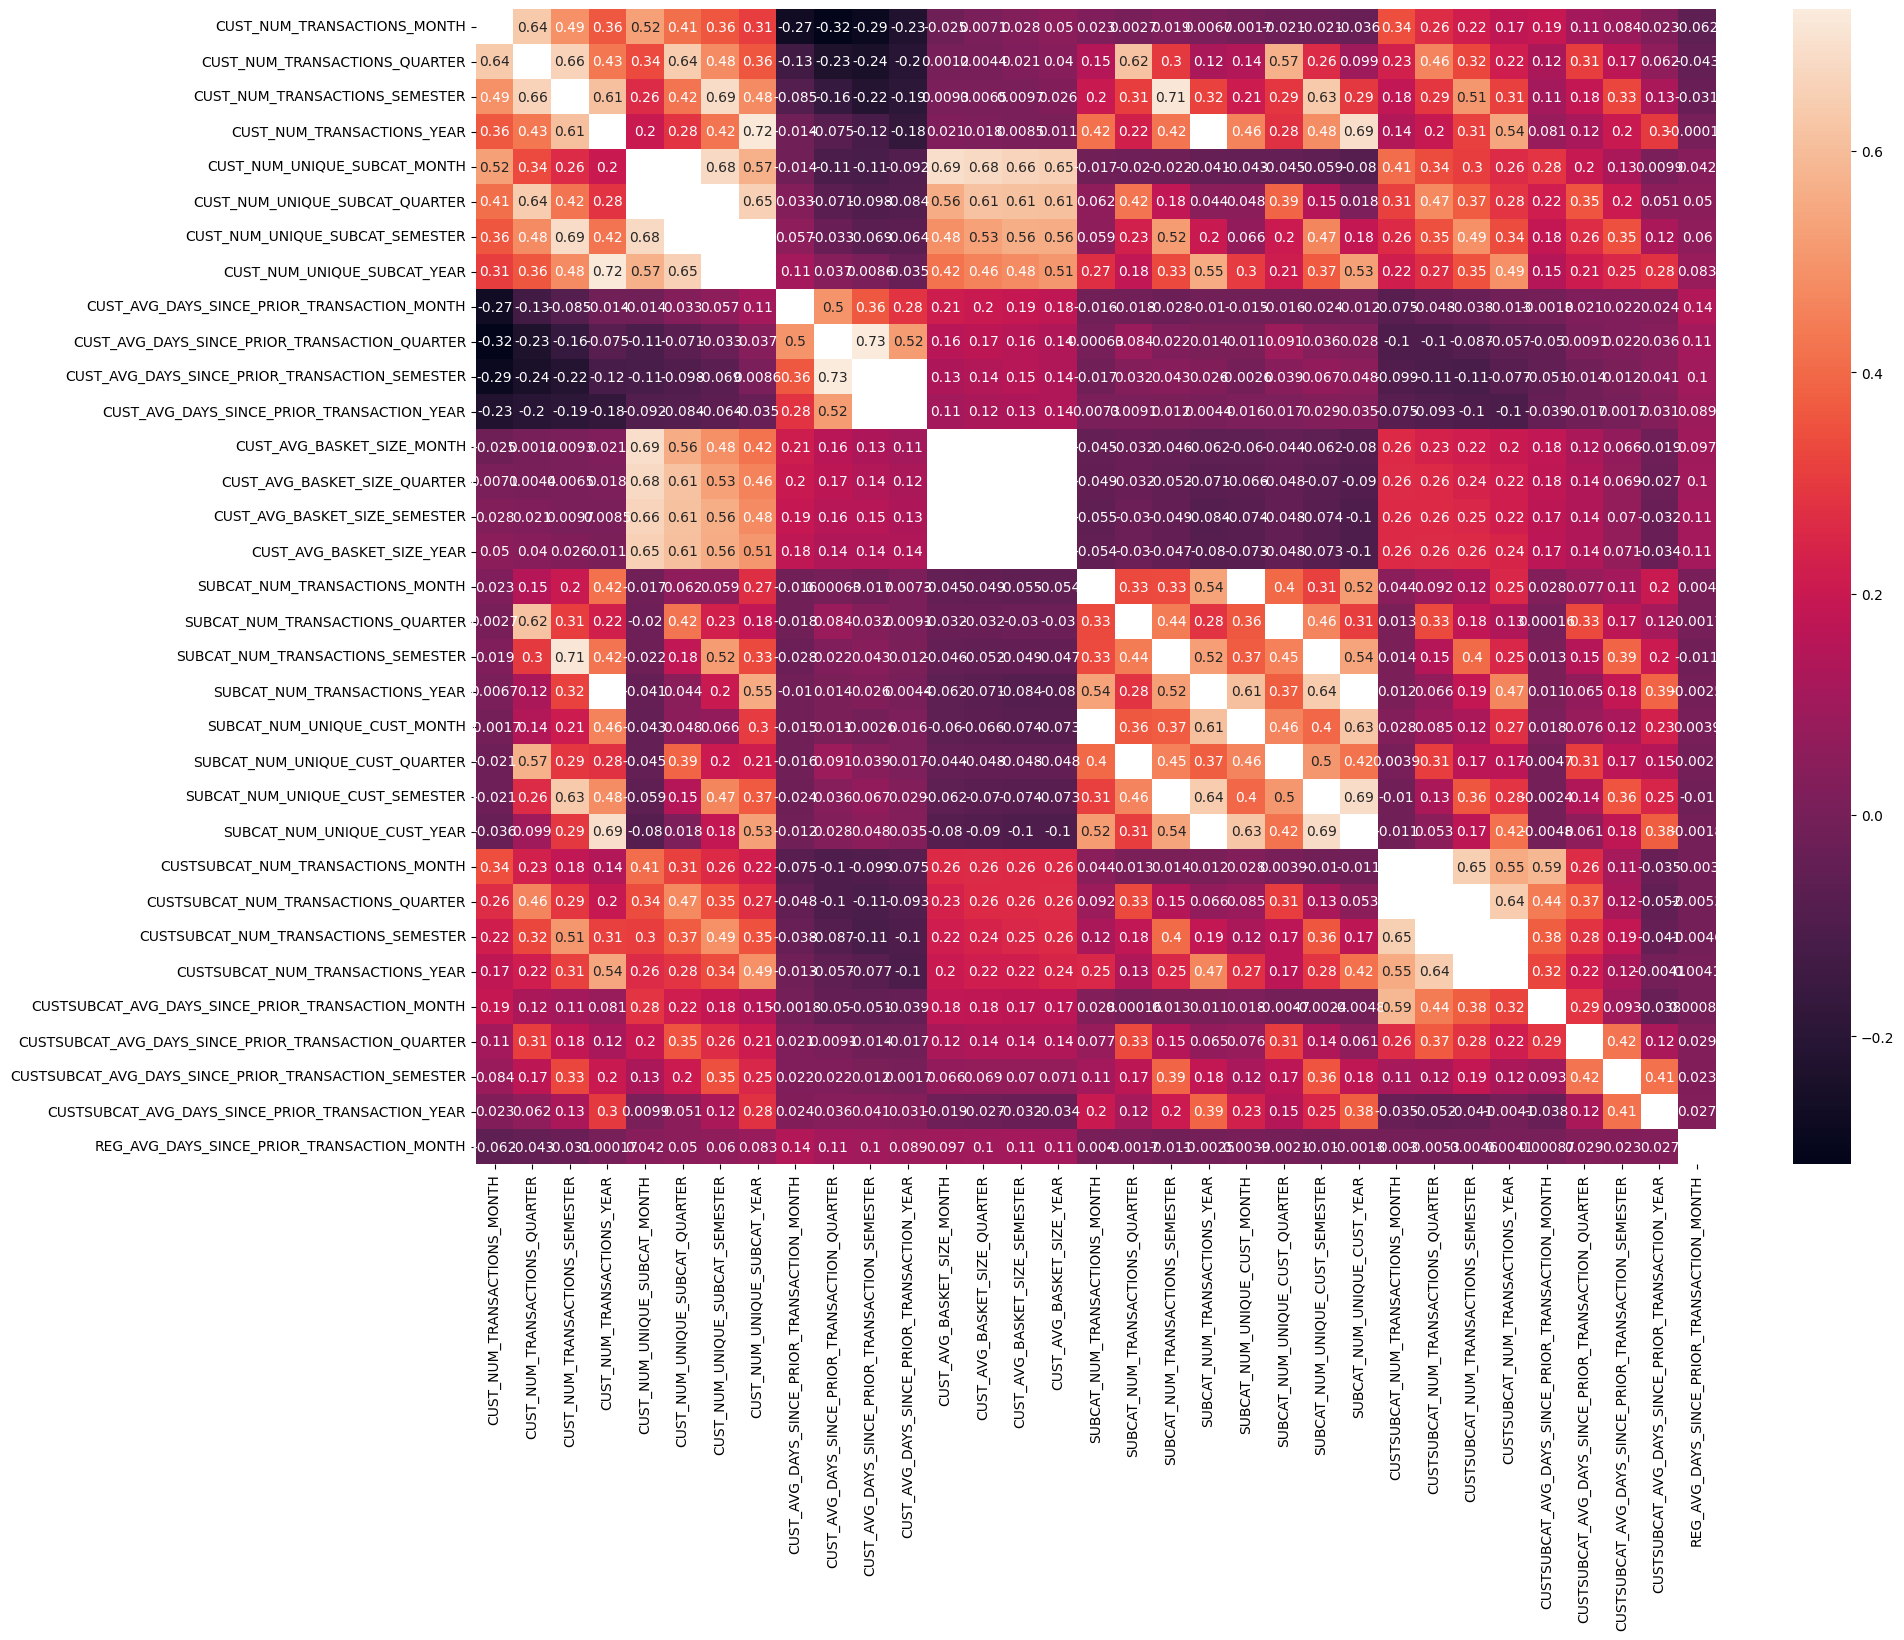

In [57]:
# set the threshold
threshold = 0.75

# keep only the correlations above the threshold
corr = corr[corr < threshold]

# Create the figure and the axes objectsa
fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(corr,annot = True)

In [13]:
# Calculate the correlation matrix
corr = df_200k[numerical_columns].corr()

# Set the threshold
threshold = 0.75

# Filter correlations below the threshold
corr_filtered = corr[corr < threshold]

# Get the list of columns below the threshold
columns_below_threshold = corr_filtered.columns.tolist()

print("Columns below the threshold:")
print(columns_below_threshold)

Columns below the threshold:
['CUST_NUM_TRANSACTIONS_MONTH', 'CUST_NUM_TRANSACTIONS_QUARTER', 'CUST_NUM_TRANSACTIONS_SEMESTER', 'CUST_NUM_TRANSACTIONS_YEAR', 'CUST_NUM_UNIQUE_SUBCAT_MONTH', 'CUST_NUM_UNIQUE_SUBCAT_QUARTER', 'CUST_NUM_UNIQUE_SUBCAT_SEMESTER', 'CUST_NUM_UNIQUE_SUBCAT_YEAR', 'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH', 'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_QUARTER', 'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_SEMESTER', 'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_YEAR', 'CUST_AVG_BASKET_SIZE_MONTH', 'CUST_AVG_BASKET_SIZE_QUARTER', 'CUST_AVG_BASKET_SIZE_SEMESTER', 'CUST_AVG_BASKET_SIZE_YEAR', 'SUBCAT_NUM_TRANSACTIONS_MONTH', 'SUBCAT_NUM_TRANSACTIONS_QUARTER', 'SUBCAT_NUM_TRANSACTIONS_SEMESTER', 'SUBCAT_NUM_TRANSACTIONS_YEAR', 'SUBCAT_NUM_UNIQUE_CUST_MONTH', 'SUBCAT_NUM_UNIQUE_CUST_QUARTER', 'SUBCAT_NUM_UNIQUE_CUST_SEMESTER', 'SUBCAT_NUM_UNIQUE_CUST_YEAR', 'CUSTSUBCAT_NUM_TRANSACTIONS_MONTH', 'CUSTSUBCAT_NUM_TRANSACTIONS_QUARTER', 'CUSTSUBCAT_NUM_TRANSACTIONS_SEMESTER', 'CUSTSUBCA

## Variance Inflation Index

In [206]:
df_200k = df_200k.drop(columns=['QUARTER','SEMESTER','CAT_CD_EXT', 'YEAR', 'MONTH', 'SUBCAT_CD_EXT'], axis=1)

In [207]:
# One-hot encoding categorical variables
df_200k = pd.get_dummies(df_200k, columns=['GENDER','SEG_LIFESTAGE_CD', 'FAMILY_MEMBERS'])
df_200k

,CUST_NUM_TRANSACTIONS_MONTH,CUST_NUM_TRANSACTIONS_QUARTER,CUST_NUM_TRANSACTIONS_SEMESTER,CUST_NUM_TRANSACTIONS_YEAR,CUST_TOTAL_QTY_BOUGHT_MONTH,CUST_TOTAL_QTY_BOUGHT_QUARTER,CUST_TOTAL_QTY_BOUGHT_SEMESTER,CUST_TOTAL_QTY_BOUGHT_YEAR,CUST_NUM_UNIQUE_SUBCAT_MONTH,CUST_NUM_UNIQUE_SUBCAT_QUARTER,CUST_NUM_UNIQUE_SUBCAT_SEMESTER,CUST_NUM_UNIQUE_SUBCAT_YEAR,CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH,CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_QUARTER,CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_SEMESTER,CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_YEAR,REG_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH,CUST_AVG_BASKET_SIZE_MONTH,CUST_AVG_BASKET_SIZE_QUARTER,CUST_AVG_BASKET_SIZE_SEMESTER,CUST_AVG_BASKET_SIZE_YEAR,SUBCAT_NUM_TRANSACTIONS_MONTH,SUBCAT_NUM_TRANSACTIONS_QUARTER,SUBCAT_NUM_TRANSACTIONS_SEMESTER,SUBCAT_NUM_TRANSACTIONS_YEAR,SUBCAT_TOTAL_QTY_BOUGHT_MONTH,SUBCAT_TOTAL_QTY_BOUGHT_QUARTER,SUBCAT_TOTAL_QTY_BOUGHT_SEMESTER,SUBCAT_TOTAL_QTY_BOUGHT_YEAR,SUBCAT_NUM_UNIQUE_CUST_MONTH,SUBCAT_NUM_UNIQUE_CUST_QUARTER,SUBCAT_NUM_UNIQUE_CUST_SEMESTER,SUBCAT_NUM_UNIQUE_CUST_YEAR,CUSTSUBCAT_NUM_TRANSACTIONS_MONTH,CUSTSUBCAT_NUM_TRANSACTIONS_QUARTER,CUSTSUBCAT_NUM_TRANSACTIONS_SEMESTER,CUSTSUBCAT_NUM_TRANSACTIONS_YEAR,CUSTSUBCAT_TOTAL_QTY_BOUGHT_MONTH,CUSTSUBCAT_TOTAL_QTY_BOUGHT_QUARTER,CUSTSUBCAT_TOTAL_QTY_BOUGHT_SEMESTER,CUSTSUBCAT_TOTAL_QTY_BOUGHT_YEAR,CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH,CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_QUARTER,CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_SEMESTER,CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_YEAR,SEG_LIFESTYLE_CD,TARGET,fulldate,GENDER_F,GENDER_M,SEG_LIFESTAGE_CD_1,SEG_LIFESTAGE_CD_2,SEG_LIFESTAGE_CD_3,SEG_LIFESTAGE_CD_4,SEG_LIFESTAGE_CD_5,SEG_LIFESTAGE_CD_6,"FAMILY_MEMBERS_(0, 0)","FAMILY_MEMBERS_(1, 2)","FAMILY_MEMBERS_(3, 8)"
181911,0.47,-0.54,-0.91,-1.17,102,102,102,102,2.12,1.01,0.39,-0.16,-0.06,-0.20,-0.25,-0.26,1.92,0.93,1.02,1.06,1.11,-0.96,-1.27,-1.51,-1.56,4304,4304,4304,4304,-1.36,-1.51,-1.95,-2.13,0.88,0.09,-0.30,-0.57,2,2,2,2,-0.24,-0.50,-0.64,-0.75,2,1,2021-01,1,0,0,0,0,1,0,0,0,0,1
280421,-0.18,-0.83,-1.07,-1.25,8,8,8,8,-1.23,-1.49,-1.72,-1.99,-0.64,-0.72,-0.78,-0.83,0.00,-1.11,-1.22,-1.28,-1.36,-0.96,-1.27,-1.51,-1.56,4304,4304,4304,4304,-1.36,-1.51,-1.95,-2.13,0.88,0.09,-0.30,-0.57,2,2,2,2,0.78,-0.06,-0.37,-0.57,1,0,2021-01,1,0,0,0,0,1,0,0,0,0,1
326741,0.80,-0.40,-0.84,-1.13,93,93,93,93,0.53,-0.18,-0.61,-1.03,-0.35,-0.46,-0.51,-0.55,3.00,0.71,0.78,0.81,0.84,-0.96,-1.27,-1.51,-1.56,4304,4304,4304,4304,-1.36,-1.51,-1.95,-2.13,-0.76,-0.80,-0.84,-0.87,0,0,0,0,-0.45,-0.59,-0.70,-0.79,1,1,2021-01,1,0,0,0,0,0,1,0,0,1,0
601824,-0.18,-0.83,-1.07,-1.25,48,48,48,48,-0.22,-0.74,-1.09,-1.44,0.49,0.29,0.25,0.28,6.25,0.06,0.06,0.06,0.06,-0.96,-1.27,-1.51,-1.56,4304,4304,4304,4304,-1.36,-1.51,-1.95,-2.13,-0.76,-0.80,-0.84,-0.87,0,0,0,0,-0.45,-0.59,-0.70,-0.79,1,0,2021-01,0,1,0,0,0,0,1,0,1,0,0
555509,0.80,-0.40,-0.84,-1.13,118,118,118,118,2.45,1.26,0.60,0.03,-0.35,-0.46,-0.51,-0.55,8.00,0.86,0.95,0.99,1.03,-0.96,-1.27,-1.51,-1.56,4304,4304,4304,4304,-1.36,-1.51,-1.95,-2.13,0.06,-0.36,-0.57,-0.72,2,2,2,2,-0.45,-0.59,-0.70,-0.79,1,0,2021-01,0,1,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1247578,-1.17,-0.69,-0.28,0.64,3,13,54,276,-1.56,-1.24,-0.66,-0.61,5.47,0.97,1.30,0.37,12.00,-1.24,-1.13,-0.86,-0.79,-0.12,0.10,1.19,1.55,4822,9860,26423,56430,0.05,0.35,1.41,1.47,-0.76,-0.80,-0.84,-0.72,0,0,0,1,-0.45,-0.59,-0.70,-0.79,2,0,2022-11,1,0,0,0,1,0,0,0,0,0,1
1194932,0.80,1.02,2.24,3.23,59,140,358,816,0.87,1.07,1.39,1.22,-0.44,-0.56,-0.65,-0.74,2.70,-0.10,-0.02,-0.10,-0.12,-0.12,0.10,1.19,1.55,4822,9860,26423,56430,0.05,0.35,1.41,1.47,0.88,0.09,0.24,0.65,2,2,4,10,2.21,0.56,1.94,0.49,1,0,2022-11,1,0,0,0,0,0,1,0,0,1,0
1015115,-1.17,-0.54,0.74,1.94,8,45,180,455,-1.14,-0.24,0.91,1.22,0.94,0.92,-0.04,-0.40,4.14,-0

In [208]:
# compute the vif for all given features
def compute_vif(considered_features):
    X = df_200k[considered_features]
    # the calculation of variance inflation requires a constant
    X['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    to_keep = vif[vif['VIF'] < 10]
    cols = to_keep['Variable'].tolist()
    
    
    return vif, cols

In [209]:
vif, cols = compute_vif(numerical_columns)

In [18]:
vif.sort_values('VIF', ascending=False)

,Variable,VIF
20,SUBCAT_NUM_UNIQUE_CUST_MONTH,118.02
16,SUBCAT_NUM_TRANSACTIONS_MONTH,100.53
21,SUBCAT_NUM_UNIQUE_CUST_QUARTER,83.84
17,SUBCAT_NUM_TRANSACTIONS_QUARTER,73.66
22,SUBCAT_NUM_UNIQUE_CUST_SEMESTER,43.76
18,SUBCAT_NUM_TRANSACTIONS_SEMESTER,34.82
6,CUST_NUM_UNIQUE_SUBCAT_SEMESTER,26.73
23,SUBCAT_NUM_UNIQUE_CUST_YEAR,23.64
14,CUST_AVG_BASKET_SIZE_SEMESTER,22.89
5,CUST_NUM_UNIQUE_SUBCAT_QUARTER,21.65


In [210]:
num = ['SEG_LIFESTYLE_CD', 'GENDER_F', 'GENDER_M', 'SEG_LIFESTAGE_CD_1',
       'SEG_LIFESTAGE_CD_2', 'SEG_LIFESTAGE_CD_3', 'SEG_LIFESTAGE_CD_4',
       'SEG_LIFESTAGE_CD_5', 'SEG_LIFESTAGE_CD_6', 'FAMILY_MEMBERS_(0, 0)',
       'FAMILY_MEMBERS_(1, 2)', 'FAMILY_MEMBERS_(3, 8)', 'fulldate', 'REG_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH']

df_200k = df_200k[cols + num]

In [20]:
# df_200k = df_200k.drop('TARGET', axis=1)

In [21]:
# df_200k = df_200k.drop(columns=['CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_QUARTER','CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_SEMESTER',
#                                 'CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_YEAR'])

In [22]:
# df_200k = df_200k[columns_below_threshold + num]
# df_200k

# Machine Learning

In [195]:
results_df = pd.DataFrame()

In [69]:
# def random_oversampling(x_train,y_train):
#     ros = RandomOverSampler(random_state=101)
#     X_train, y_train = ros.fit_resample(x_train, y_train)
    
#     return X_train, y_train

# def roSMOTE(x_train,y_train):
#     os = SMOTE(random_state=101)
#     X_train, y_train = os.fit_resample(x_train, y_train)
#     y_train = y_train.astype(np.float64)
#     X_train = y_train.astype(np.float64)
#     return X_train, y_train

# def random_undersampling(x_train,y_train):
#     rus = RandomUnderSampler(random_state=101)
#     X_train, y_train = rus.fit_resample(x_train, y_train)
    
#     return X_train, y_train

In [196]:
def reg_metrics(pred_model, x_train, x_test, y_train, y_test):
    """ Function takes in training and testing sets, prediction model, 
    and ouputs the below metrics:
    1. R² or Coefficient of Determination.
    2. Adjusted R²
    3. Mean Squared Error(MSE)
    4. Root-Mean-Squared-Error(RMSE).
    5. Mean-Absolute-Error(MAE).
    """
    global r2
    global adj_r2
    global mse
    global rmse
    global mae
    
    # Get predicted values on x_test
    y_pred = pred_model.predict(x_test)

    #1 & 2 Coefficient of Determination (R² & Adjusted R²)
    print("\n\t--- Coefficient of Determination (R² & Adjusted R²) ---")
    r2 = metrics.r2_score(y_pred=y_pred, y_true=y_test)
    adj_r2 = 1 - (1-r2)*(len(y_train)-1)/(len(y_train)-x_train.shape[1]-1)

    print(f"R²\t\t: {r2:.2f}")
    print(f"Adjusted R²\t: {adj_r2:.2f}")

    #3 & 4. MSE and RMSE
    print("\n\t--- Mean Squared Error (MSE & RMSE) ---")
   
    mse = metrics.mean_squared_error(y_pred=y_pred, y_true=y_test, squared=True)
    rmse = metrics.mean_squared_error(y_pred=y_pred, y_true=y_test, squared=False)
    
    print(f"MSE\t: {mse:.2f}")
    print(f"RMSE\t: {rmse:.2f}")

    #5. MAE
    print("\n\t--- Mean Absolute Error (MAE) ---")
    mae = metrics.mean_absolute_error(y_pred=y_pred, y_true=y_test)
    print(f"RMSE\t: {mae:.2f}")
    
    # # Return Accuracy
    # #train_acc = "{:.2f}".format(pred_model.score(x_train, y_train)*100)
    # #test_acc = "{:.2f}".format(pred_model.score(x_test, y_test)*100)
    
    # #Convert variables to a rounded format 
    # r2_formatted = "{:.2f}%".format(r2 * 100)
    # adj_r2_formatted = "{:.2f}%".format(adj_r2 * 100)
    # mse_formatted = "{:.2f}".format(mse)
    # rmse_formatted = "{:.2f}".format(rmse)
    # mae_formatted = "{:.2f}".format(mae)
    
    # # Return metrics as a dictionary
    # metrics_dict = {
    #     'R²': r2_formatted,
    #     'Adjusted R²': adj_r2_formatted,
    #     'MSE': mse_formatted,
    #     'RMSE': rmse_formatted,
    #     'MAE': mae_formatted
    # }
    
    #return metrics_dict

In [71]:
# def cross_val_reg(df_ML, model, resampling_tecnique, model_name):
#     global results_df
#     print(f'\t------- {model_name} -------\n')

#     timestamps = df_ML['fulldate'].sort_values().unique()

#     # store each of the metrics in an array for each one
#     rsquared_array = np.array([])
#     adjrsquared_array = np.array([])
#     mse_array = np.array([])
#     rmse_array = np.array([])
#     mae_array = np.array([])

#     i = 0
#     ii = 1
#     max_timestamp = timestamps.max() - 2
#     while timestamps[i] < max_timestamp:
#             print('\n')
#             print('-' * 50)
#             print(f'\n\n\t---- Start Iteration {ii} ----\n')
#             print("\n\t----- Iteration Info -----")
#             print(f'\nTreino feito com os meses: {timestamps[i]} até {timestamps[i]+2}') # 11   
#             train = df_ML[df_ML['fulldate'].isin([timestamps[i], timestamps[i]+1, timestamps[i]+2])]
#             print(f'Teste feito com o mês: {timestamps[i]+3}\n')

#             # test and train split
#             train_tune = train.groupby('fulldate').sample(frac=0.3, random_state=101)
#             train_tune.value_counts('fulldate').sort_index()
#             X_train_cv = train.drop(['REG_AVG_DAYS_FOR_NEXT_TRANSACTION_30_DAYS','fulldate'], axis=1)
#             y_train_cv = train['REG_AVG_DAYS_FOR_NEXT_TRANSACTION_30_DAYS'].astype(int)
#             y_train_cv.value_counts('fulldate').sort_index()
#             X_train_tune = train_tune.drop(['REG_AVG_DAYS_FOR_NEXT_TRANSACTION_30_DAYS','fulldate'], axis=1)
#             y_train_tune = train_tune['REG_AVG_DAYS_FOR_NEXT_TRANSACTION_30_DAYS'].astype(int)
#             y_train_tune.value_counts('fulldate').sort_index() 
                           
#             # resampling technique
#             X_train_cv, y_train_cv = resampling_tecnique(X_train_cv, y_train_cv)
#             X_train_tune, y_train_tune = random_undersampling(X_train_tune, y_train_tune)

#             print('X_train_cv shape: ', X_train_cv.shape)
#             print('X_train_tune shape: ', X_train_tune.shape)
            
#             test = df_ML[df_ML['fulldate'] == timestamps[i]+3] # 12
            
#             X_test = test.drop(['REG_AVG_DAYS_FOR_NEXT_TRANSACTION_30_DAYS', 'fulldate'], axis=1)
#             #X_test.value_counts('fulldate').sort_index() 
#             y_test = test['REG_AVG_DAYS_FOR_NEXT_TRANSACTION_30_DAYS'].astype(int)
#             y_test.value_counts('fulldate').sort_index() 
#             print('X_test shape: ', X_test.shape)
#             print('\n\t--------------------------')
#             # predictions for metrics
#             y_pred = model(X_train_cv, y_train_cv, X_train_tune, y_train_tune, X_test, y_test)
            
#             #append rsquared to rsquared_array
#             rsquared_array = np.append(rsquared_array, r2)
#             #append adjrsquared to ajdrsquared_array
#             adjrsquared_array = np.append(adjrsquared_array, adj_r2)
#             #append mse to mse_array
#             mse_array = np.append(mse_array, mse)
#             #append rmse to rmse_array
#             rmse_array = np.append(rmse_array, mse)
#             #append mae to mae_array
#             mae_array = np.append(mae_array, mae)
            
#             i += 1
#             ii += 1
#     else:
#         print('\n----------------------------\n\n')
#         print(f'R² Mean of all iterations : {np.mean(rsquared_array)}')
#         print(f'Adjusted R² Mean of all iterations : {np.mean(adjrsquared_array)}')
#         print(f'MSE Mean of all iterations: {np.mean(mse_array)}')
#         print(f'RMSE mean of all iterations: {np.mean(rmse_array)}')
#         print(f'MAE mean of all iterations: {np.mean(mae_array)}')

#         # Append the results to the dataframe
#         results_df = results_df.append({
#         'Model': model_name,  # Replace 'Model Name' with the actual model name
#         'R² Mean': np.mean(rsquared_array),
#         'Adjusted R² Mean': np.mean(adjrsquared_array),
#         'MSE Mean': np.mean(mse_array),
#         'RMSE Mean': np.mean(rmse_array),
#         'MAE Mean': np.mean(mae_array)}, ignore_index=True)
        
#     return X_train_cv, y_train_cv,X_test, y_test, y_pred, results_df 



In [197]:
def cross_val_reg(df_ML, model, model_name):
    global results_df
    print(f'\t------- {model_name} -------\n')

    timestamps = df_ML['fulldate'].sort_values().unique()

    # store each of the metrics in an array for each one
    rsquared_array = np.array([])
    adjrsquared_array = np.array([])
    mse_array = np.array([])
    rmse_array = np.array([])
    mae_array = np.array([])

    i = 0
    ii = 1
    max_timestamp = timestamps.max() - 2
    while timestamps[i] < max_timestamp:
            print('\n')
            print('-' * 50)
            print(f'\n\n\t---- Start Iteration {ii} ----\n')
            print("\n\t----- Iteration Info -----")
            print(f'\nTreino feito com os meses: {timestamps[i]} até {timestamps[i]+2}') # 11   
            train = df_ML[df_ML['fulldate'].isin([timestamps[i], timestamps[i]+1, timestamps[i]+2])]
            print(f'Teste feito com o mês: {timestamps[i]+3}\n')

            # test and train split
            train_tune = train.groupby('fulldate').sample(frac=0.3, random_state=101)
            train_tune.value_counts('fulldate').sort_index()
            X_train_cv = train.drop(['REG_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH','fulldate'], axis=1)
            y_train_cv = train['REG_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH'].astype(int)
            y_train_cv.value_counts('fulldate').sort_index()
            X_train_tune = train_tune.drop(['REG_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH','fulldate'], axis=1)
            y_train_tune = train_tune['REG_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH'].astype(int)
            y_train_tune.value_counts('fulldate').sort_index() 
                           
            # resampling technique
            #X_train_cv, y_train_cv = resampling_tecnique(X_train_cv, y_train_cv)
            #X_train_tune, y_train_tune = random_undersampling(X_train_tune, y_train_tune)

            print('X_train_cv shape: ', X_train_cv.shape)
            print('X_train_tune shape: ', X_train_tune.shape)
            
            test = df_ML[df_ML['fulldate'] == timestamps[i]+3] # 12
            
            X_test = test.drop(['REG_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH', 'fulldate'], axis=1)
            #X_test.value_counts('fulldate').sort_index() 
            y_test = test['REG_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH'].astype(int)
            y_test.value_counts('fulldate').sort_index() 
            print('X_test shape: ', X_test.shape)
            print('\n\t--------------------------')
            # predictions for metrics
            y_pred = model(X_train_cv, y_train_cv, X_train_tune, y_train_tune, X_test, y_test)
            
            #append rsquared to rsquared_array
            rsquared_array = np.append(rsquared_array, r2)
            #append adjrsquared to ajdrsquared_array
            adjrsquared_array = np.append(adjrsquared_array, adj_r2)
            #append mse to mse_array
            mse_array = np.append(mse_array, mse)
            #append rmse to rmse_array
            rmse_array = np.append(rmse_array, mse)
            #append mae to mae_array
            mae_array = np.append(mae_array, mae)
            
            i += 1
            ii += 1
    else:
        print('\n----------------------------\n\n')
        print(f'R² Mean of all iterations : {np.mean(rsquared_array)}')
        print(f'Adjusted R² Mean of all iterations : {np.mean(adjrsquared_array)}')
        print(f'MSE Mean of all iterations: {np.mean(mse_array)}')
        print(f'RMSE mean of all iterations: {np.mean(rmse_array)}')
        print(f'MAE mean of all iterations: {np.mean(mae_array)}')

        # Append the results to the dataframe
        results_df = results_df.append({
        'Model': model_name,  # Replace 'Model Name' with the actual model name
        'R² Mean': np.mean(rsquared_array),
        'Adjusted R² Mean': np.mean(adjrsquared_array),
        'MSE Mean': np.mean(mse_array),
        'RMSE Mean': np.mean(rmse_array),
        'MAE Mean': np.mean(mae_array)}, ignore_index=True)
        
    return X_train_cv, y_train_cv,X_test, y_test, y_pred, results_df 



In [73]:
# def imp_df(column_names, importances):
#     df = pd.DataFrame({'feature': column_names,
#     'feature_importance': importances}).sort_values('feature_importance', ascending = False).reset_index(drop = True)
#     return df

In [74]:
# def LR(X_train, y_train, X_train_tune, y_train_tune, X_test, y_test):
#     clf = Pipeline([
#         # ('pca', PCA()),
#         ('clf', LinearRegression())
#     ])

#     param_grid = {}
    


#     #fs = SelectKBest(score_func=f_regression, k=10)
#     # apply feature selection
#     #X_selected = fs.fit(X_train_tune, y_train_tune)
#     #X_test = X_selected.transform(X_test)
#     #X_train = X_selected.transform(X_train)
#     #names = list(X_selected.feature_names_in_)
#     #print('\n\nNumber of selected features: {}'.format(names))
#     #Use SequentialFeatureSelector for forward/backward selection
#     #sfs_backward = SequentialFeatureSelector(clf, n_features_to_select=None, direction='backward', scoring='r2', cv=None, n_jobs=-1)  # Does 5-Fold CV

#     sfs1 = sfs(clf['clf'], k_features=15, forward=True, verbose=2, scoring='neg_mean_squared_error')
#     sfs1 = sfs1.fit(X_train_tune, y_train_tune)

#     # Fit the feature selector to the training data
#     #sfs_backward.fit(X_train_tune, y_train_tune)

#     # Get the selected features and transform the data
#     X_train = sfs1.transform(X_train)
#     X_train = pd.DataFrame(X_train)
#     X_test = sfs1.transform(X_test)
#     print(f'X_train Shape: {X_train.shape}')

#     #print('\n\nNumber of selected features: {}'.format(sfs_backward.n_features_to_select_))
#     #print('Features selected: {}'.format(sfs_backward.feature_names_in_[sfs_backward.support_]))
#     feat_names = list(sfs1.k_feature_names_)
#     print('\n\nNumber of selected features: {}'.format(feat_names))

#     gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='r2', cv=2, verbose=1, n_jobs=-1)
#     LR = Pipeline([('gs', gs)])

#     LR.fit(X_train, y_train)
        
#     # # create permutation importance object using model
#     # # and fit on test set
#     # perm = PermutationImportance(LR, random_state=1).fit(X_test, y_test)
    
#     # # display weights using PermutationImportance object
#     # eli5.show_weights(perm)
#     # perm = PermutationImportance(LR, cv = None, refit = False, n_iter = 50).fit(X_train, y_train)
#     # perm_imp_eli5 = imp_df(X_train.columns, perm.feature_importances_)
#     # Calculate permutation importances
#     # perm = PermutationImportance(LR, X_train, y_train)

#     # # Create a DataFrame to store the importances
#     # perm_imp_eli5 = pd.DataFrame({'Feature': X_train.columns, 'Importance': perm.importances_mean})

#     # Display the importances
#     #print(perm_imp_eli5)
    
#     print('\n------- IMPORTANCE --------')
#     # Get the final estimator from the pipeline
#     final_estimator = LR.named_steps['gs'].best_estimator_['clf']

#     # Get feature importances (coefficients)
#     feature_importances = final_estimator.coef_

#     # Summarize feature importance
#     for i, v in enumerate(feature_importances):
#         print('Feature: %0d, Score: %.10f' % (i, v))

#     # # plot feature importance
#     # plt.bar([x for x in range(len(feature_importances))], feature_importances)
#     # plt.show()
#     print('\n---------------------\n')
#     reg_metrics(LR, X_train, X_test, y_train, y_test)


In [198]:
import time

In [199]:
def LR(X_train, y_train, X_train_tune, y_train_tune, X_test, y_test):
    start_time = time.time()
    clf = Pipeline([
        # ('pca', PCA()),
        ('clf', LinearRegression())
    ])
    param_grid = {}

    # Use SequentialFeatureSelector for forward/backward selection
    sfs_backward = SequentialFeatureSelector(clf, n_features_to_select='auto', direction='forward',
                                             scoring='neg_mean_squared_error', cv=None, n_jobs=-1)  # Does 5-Fold CV

    # Fit the feature selector to the training data
    sfs_backward.fit(X_train_tune, y_train_tune)

    # Get the selected features and transform the data
    X_train = sfs_backward.transform(X_train)
    X_test = sfs_backward.transform(X_test)
    print(f'X_train Shape: {X_train.shape}')

    print('\n\nNumber of selected features: {}'.format(sfs_backward.n_features_to_select_))
    print('Features selected: {}'.format(sfs_backward.feature_names_in_[sfs_backward.support_]))

    gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='r2', cv=2, verbose=1, n_jobs=-1)
    LR = Pipeline([('gs', gs)])

    LR.fit(X_train, y_train)
    print('\n------- IMPORTANCE --------')
    # Get the final estimator from the pipeline
    final_estimator = LR.named_steps['gs'].best_estimator_['clf']

    # Get feature importances (coefficients)
    feature_importances = final_estimator.coef_

    # Summarize feature importance
    for i, v in enumerate(feature_importances):
        print('Feature: %0d, Score: %.20f' % (i, v))

    print('\n------------------------------')
    end_time = time.time()
    diff = end_time - start_time
    print(diff)
    reg_metrics(LR, X_train, X_test, y_train, y_test)


In [212]:
def ridge(X_train, y_train, X_train_tune, y_train_tune, X_test, y_test):
    start_time = time.time()
    clf = Pipeline([
                # ('pca', PCA()),
                ('clf', Ridge(max_iter=1000, tol=11.830e-06))])  

    param_grid = {
    'clf__alpha': (np.arange(0.001,1.0,0.001))}
    #'clf__alpha': [0.01]}

    # Use SequentialFeatureSelector for forward/backward selection
    sfs_backward = SequentialFeatureSelector(clf['clf'], n_features_to_select=0.5, direction='forward', scoring='r2', cv=None, n_jobs=-1) # Does 5-Fold CV

    # Fit the feature selector to the training data
    sfs_backward.fit(X_train_tune, y_train_tune)

    # Get the selected features and transform the data
    X_train = sfs_backward.transform(X_train)
    X_test = sfs_backward.transform(X_test)

    print('Number of selected features: {}'.format(sfs_backward.n_features_to_select_))
    #print('Features selected: {}'.format(sfs_backward.feature_names_in_[sfs_backward.support_]))
        
    gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='r2', cv=2, verbose=1, n_jobs=-1)
    RG = Pipeline([('gs', gs)]) 
        
    RG.fit(X_train,y_train)
    
    # get best parameters
    best_params = gs.best_params_
    print('\n')
    print('-' * 60)
    print('Best Parameters:')
    print(best_params)
    print('-' * 60)
    print('\n')

    print('\n------- IMPORTANCE --------')
    # Get the final estimator from the pipeline
    final_estimator = RG.named_steps['gs'].best_estimator_['clf']

    # Get feature importances (coefficients)
    feature_importances = final_estimator.coef_

    # Summarize feature importance
    for i, v in enumerate(feature_importances):
        print('Feature: %0d, Score: %.20f' % (i, v))

    print('\n------------------------------')
    end_time = time.time()
    diff = end_time - start_time
    print(diff)
    reg_metrics(RG, X_train, X_test, y_train, y_test)

In [77]:
def lasso(X_train, y_train, X_train_tune, y_train_tune, X_test, y_test):
    clf = Pipeline([
                # ('pca', PCA()),
                ('clf', Lasso(max_iter=1000, tol=11.830e-06))])  

    param_grid = {
    'clf__alpha': (np.arange(0.001,1.0,0.001))}

    # Use SequentialFeatureSelector for forward/backward selection
    sfs_backward = SequentialFeatureSelector(clf, n_features_to_select=0.5, direction='forward', scoring='r2', cv=None, n_jobs=-1) # Does 5-Fold CV

    # Fit the feature selector to the training data
    sfs_backward.fit(X_train_tune, y_train_tune)

    # Get the selected features and transform the data
    X_train = sfs_backward.transform(X_train)
    X_test = sfs_backward.transform(X_test)


    print('Number of selected features: {}'.format(sfs_backward.n_features_to_select_))
    #print('Features selected: {}'.format(sfs_backward.feature_names_in_[sfs_backward.support_])
    gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='r2', cv=2, verbose=1, n_jobs=-1)
    LS = Pipeline([('gs', gs)]) 
        
    LS.fit(X_train,y_train)

    # get best parameters
    best_params = gs.best_params_
    print('\n')
    print('-' * 60)
    print('Best Parameters:')
    print(best_params)
    print('-' * 60)
    print('\n')

    print('\n------- IMPORTANCE --------')
    # Get the final estimator from the pipeline
    final_estimator = LS.named_steps['gs'].best_estimator_['clf']

    # Get feature importances (coefficients)
    feature_importances = final_estimator.coef_

    # Summarize feature importance
    for i, v in enumerate(feature_importances):
        print('Feature: %0d, Score: %.20f' % (i, v))

    print('\n------------------------------')

    reg_metrics(LS, X_train, X_test, y_train, y_test)


In [78]:
def ElasticNetRegression(X_train, y_train, X_train_tune, y_train_tune, X_test, y_test):
    clf = Pipeline([
        # ('pca', PCA()),
        ('clf', ElasticNet(max_iter=10000,tol=11.830e-06))])

    param_grid = {
        'clf__alpha': (np.arange(0.001,1.0,0.001))
    }

    # Use SequentialFeatureSelector for forward/backward selection
    sfs_backward = SequentialFeatureSelector(
        clf['clf'], n_features_to_select=0.5, direction='forward', scoring='neg_mean_squared_error', cv=None,
        n_jobs=-1)  # Does 5-Fold CV

    # Fit the feature selector to the training data
    sfs_backward.fit(X_train_tune, y_train_tune)

    # Get the selected features and transform the data
    X_train = sfs_backward.transform(X_train)
    X_test = sfs_backward.transform(X_test)

    print('Number of selected features: {}'.format(sfs_backward.n_features_to_select_))

    gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='neg_mean_squared_error', cv=2, verbose=1,
                      n_jobs=-1)
    EN = Pipeline([('gs', gs)])

    EN.fit(X_train, y_train)

    best_params = gs.best_params_
    print('\n')
    print('-' * 60)
    print('Best Parameters:')
    print(best_params)
    print('-' * 60)
    print('\n')
    
    print('\n------- IMPORTANCE --------')
    # Get the final estimator from the pipeline
    final_estimator = EN.named_steps['gs'].best_estimator_['clf']

    # Get feature importances (coefficients)
    feature_importances = final_estimator.coef_

    # Summarize feature importance
    for i, v in enumerate(feature_importances):
        print('Feature: %0d, Score: %.20f' % (i, v))

    print('\n------------------------------')

    reg_metrics(EN, X_train, X_test, y_train, y_test)

In [214]:
def gradientboostingreg(X_train, y_train, X_train_tune, y_train_tune, X_test, y_test):
    start_time = time.time()
    clf = Pipeline([
    # ('pca', PCA()),
    ('clf', GradientBoostingRegressor())])

    param_grid = {
        'clf__alpha': (np.arange(0.001,1.0,0.005))
    }

    # Use SequentialFeatureSelector for forward/backward selection
    sfs_backward = SequentialFeatureSelector(
        clf['clf'], n_features_to_select='auto', direction='forward', scoring='r2', cv=None,
        n_jobs=-1)  # Does 5-Fold CV

    # Fit the feature selector to the training data
    sfs_backward.fit(X_train_tune, y_train_tune)

    # Get the selected features and transform the data
    X_train = sfs_backward.transform(X_train)
    X_test = sfs_backward.transform(X_test)

    print('Number of selected features: {}'.format(sfs_backward.n_features_to_select_))

    gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='r2', cv=2, verbose=1,
                      n_jobs=-1)
    GB = Pipeline([('gs', gs)])

    GB.fit(X_train, y_train)

    best_params = gs.best_params_
    print('\n')
    print('-' * 60)
    print('Best Parameters:')
    print(best_params)
    print('-' * 60)
    print('\n')
    
    print('\n------- IMPORTANCE --------')
    # Get the final estimator from the pipeline
    final_estimator = GB.named_steps['gs'].best_estimator_['clf']

    # Get feature importances
    feature_importances = final_estimator.feature_importances_

    # Summarize feature importance
    for i, v in enumerate(feature_importances):
        print('Feature: %0d, Score: %.20f' % (i, v))

    print('\n------------------------------')
    end_time = time.time()
    diff = end_time - start_time
    print(diff)

    reg_metrics(GB, X_train, X_test, y_train, y_test)

In [80]:
def randomforestreg(X_train, y_train, X_train_tune, y_train_tune, X_test, y_test):
    clf = Pipeline([
    # ('pca', PCA()),
    ('clf', RandomForestRegressor())])

    param_grid = {
        'clf__min_samples_split': (range(1,30,1)),
        'clf__min_samples_leaf': (range(1,30,1))
    }

    # Use SequentialFeatureSelector for forward/backward selection
    sfs_backward = SequentialFeatureSelector(
        clf['clf'], n_features_to_select='auto', direction='forward', scoring='r2', cv=None,
        n_jobs=-1)  # Does 5-Fold CV

    # Fit the feature selector to the training data
    sfs_backward.fit(X_train_tune, y_train_tune)

    # Get the selected features and transform the data
    X_train = sfs_backward.transform(X_train)
    X_test = sfs_backward.transform(X_test)

    print('Number of selected features: {}'.format(sfs_backward.n_features_to_select_))

    gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='r2', cv=2, verbose=1,
                      n_jobs=-1)
    RF = Pipeline([('gs', gs)])

    RF.fit(X_train, y_train)

    best_params = gs.best_params_
    print('\n')
    print('-' * 60)
    print('Best Parameters:')
    print(best_params)
    print('-' * 60)
    print('\n')
    
    print('\n------- IMPORTANCE --------')
    # Get the final estimator from the pipeline
    final_estimator = RF.named_steps['gs'].best_estimator_['clf']

    # Get feature importances
    feature_importances = final_estimator.feature_importances_

    # Summarize feature importance
    for i, v in enumerate(feature_importances):
        print('Feature: %0d, Score: %.20f' % (i, v))

    print('\n------------------------------')

    reg_metrics(RF, X_train, X_test, y_train, y_test)

In [217]:
def xgboost_regressor(X_train, y_train, X_train_tune, y_train_tune, X_test, y_test):
    start_time = time.time()
    clf = Pipeline([
        ('xgb', xgb.XGBRegressor())])

    param_grid = {
        'xgb__learning_rate': [0.001, 0.01, 0.1],
        'xgb__n_estimators': [100, 500, 1000],
        'xgb__max_depth': [3, 5, 7]
    }

    # Use SequentialFeatureSelector for forward/backward selection
    sfs_backward = SequentialFeatureSelector(clf['xgb'], n_features_to_select=0.5, direction='forward', scoring='r2', cv=None, n_jobs=-1) # Does 5-Fold CV

    # Fit the feature selector to the training data
    sfs_backward.fit(X_train_tune, y_train_tune)

    # Get the selected features and transform the data
    X_train = sfs_backward.transform(X_train)
    X_test = sfs_backward.transform(X_test)

    print('Number of selected features: {}'.format(sfs_backward.n_features_to_select_))

    gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='r2', cv=2, verbose=1, n_jobs=-1)
    XGBoost_reg = Pipeline([('gs', gs)]) 

    XGBoost_reg.fit(X_train, y_train)

    # Get best parameters
    best_params = gs.best_params_
    print('\n')
    print('-' * 60)
    print('Best Parameters:')
    print(best_params)
    print('-' * 60)
    print('\n')

    print('\n------- IMPORTANCE --------')
    # Get the final estimator from the pipeline
    final_estimator = XGBoost_reg.named_steps['gs'].best_estimator_['xgb']

    # Get feature importances
    feature_importances = final_estimator.feature_importances_

    # Summarize feature importance
    for i, v in enumerate(feature_importances):
        print('Feature: %0d, Score: %.20f' % (i, v))

    print('\n------------------------------')
    end_time = time.time()
    diff = end_time - start_time
    print(diff)
    reg_metrics(XGBoost_reg, X_train, X_test, y_train, y_test)

In [218]:
X_train_cv, y_train_cv,X_test, y_test, y_pred, results = cross_val_reg(df_200k, xgboost_regressor, 'XGBoost Regression')

	------- XGBoost Regression -------



--------------------------------------------------


	---- Start Iteration 1 ----


	----- Iteration Info -----

Treino feito com os meses: 2021-01 até 2021-03
Teste feito com o mês: 2021-04

X_train_cv shape:  (2885, 26)
X_train_tune shape:  (866, 26)
X_test shape:  (991, 26)

	--------------------------
Number of selected features: 13
Fitting 2 folds for each of 27 candidates, totalling 54 fits


------------------------------------------------------------
Best Parameters:
{'xgb__learning_rate': 0.01, 'xgb__max_depth': 3, 'xgb__n_estimators': 500}
------------------------------------------------------------



------- IMPORTANCE --------
Feature: 0, Score: 0.28227847814559936523
Feature: 1, Score: 0.05345422402024269104
Feature: 2, Score: 0.02380224131047725677
Feature: 3, Score: 0.00000000000000000000
Feature: 4, Score: 0.04370525479316711426
Feature: 5, Score: 0.04871462285518646240
Feature: 6, Score: 0.08356679230928421021
Feature: 7, Score: 

In [211]:
X_train_cv, y_train_cv,X_test, y_test, y_pred, results = cross_val_reg(df_200k, LR, 'Linear Regression')

	------- Linear Regression -------



--------------------------------------------------


	---- Start Iteration 1 ----


	----- Iteration Info -----

Treino feito com os meses: 2021-01 até 2021-03
Teste feito com o mês: 2021-04

X_train_cv shape:  (2885, 26)
X_train_tune shape:  (866, 26)
X_test shape:  (991, 26)

	--------------------------
X_train Shape: (2885, 13)


Number of selected features: 13
Features selected: ['CUST_NUM_TRANSACTIONS_MONTH'
 'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH'
 'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_QUARTER'
 'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_YEAR' 'CUST_AVG_BASKET_SIZE_MONTH'
 'CUSTSUBCAT_NUM_TRANSACTIONS_QUARTER'
 'CUSTSUBCAT_NUM_TRANSACTIONS_SEMESTER'
 'CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_SEMESTER'
 'CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_YEAR' 'SEG_LIFESTAGE_CD_1'
 'SEG_LIFESTAGE_CD_2' 'SEG_LIFESTAGE_CD_4' 'FAMILY_MEMBERS_(0, 0)']
Fitting 2 folds for each of 1 candidates, totalling 2 fits

------- IMPORTANCE --------
Feature: 0

In [213]:
X_train_cv, y_train_cv,X_test, y_test, y_pred, results = cross_val_reg(df_200k, ridge, 'Ridge Regression')

	------- Ridge Regression -------



--------------------------------------------------


	---- Start Iteration 1 ----


	----- Iteration Info -----

Treino feito com os meses: 2021-01 até 2021-03
Teste feito com o mês: 2021-04

X_train_cv shape:  (2885, 26)
X_train_tune shape:  (866, 26)
X_test shape:  (991, 26)

	--------------------------
Number of selected features: 13
Fitting 2 folds for each of 999 candidates, totalling 1998 fits


------------------------------------------------------------
Best Parameters:
{'clf__alpha': 0.999}
------------------------------------------------------------



------- IMPORTANCE --------
Feature: 0, Score: -0.48014821540550622903
Feature: 1, Score: 0.23402140511600175166
Feature: 2, Score: 0.17588413579675055143
Feature: 3, Score: 0.02585696621255284891
Feature: 4, Score: -0.24659033368463220692
Feature: 5, Score: 0.01349946231612195180
Feature: 6, Score: 0.07503992226931639753
Feature: 7, Score: 0.04666743563955321611
Feature: 8, Score: 0.0310783

In [40]:
X_train_cv, y_train_cv,X_test, y_test, y_pred, results = cross_val_reg(df_200k, lasso, 'Lasso Regression')

	------- Lasso Regression -------



--------------------------------------------------


	---- Start Iteration 1 ----


	----- Iteration Info -----

Treino feito com os meses: 2021-01 até 2021-03
Teste feito com o mês: 2021-04

X_train_cv shape:  (2885, 26)
X_train_tune shape:  (866, 26)
X_test shape:  (991, 26)

	--------------------------
Number of selected features: 13
Fitting 2 folds for each of 999 candidates, totalling 1998 fits


------------------------------------------------------------
Best Parameters:
{'clf__alpha': 0.015}
------------------------------------------------------------



------- IMPORTANCE --------
Feature: 0, Score: -0.02521117090085664425
Feature: 1, Score: 0.01484421976344856876
Feature: 2, Score: 0.00000000000000000000
Feature: 3, Score: 0.00000000000000000000
Feature: 4, Score: 0.02483653573872325257
Feature: 5, Score: 0.00000000000000000000
Feature: 6, Score: -0.00000000000000000000
Feature: 7, Score: -0.00000000000000000000
Feature: 8, Score: -0.00000

In [41]:
X_train_cv, y_train_cv,X_test, y_test, y_pred, results = cross_val_reg(df_200k, ElasticNetRegression, 'ElasticNet Regression')

	------- ElasticNet Regression -------



--------------------------------------------------


	---- Start Iteration 1 ----


	----- Iteration Info -----

Treino feito com os meses: 2021-01 até 2021-03
Teste feito com o mês: 2021-04

X_train_cv shape:  (2885, 26)
X_train_tune shape:  (866, 26)
X_test shape:  (991, 26)

	--------------------------
Number of selected features: 13
Fitting 2 folds for each of 999 candidates, totalling 1998 fits


------------------------------------------------------------
Best Parameters:
{'clf__alpha': 0.031}
------------------------------------------------------------



------- IMPORTANCE --------
Feature: 0, Score: -0.02472648404015302670
Feature: 1, Score: 0.01461438859921654343
Feature: 2, Score: 0.00000000000000000000
Feature: 3, Score: 0.00000000000000000000
Feature: 4, Score: 0.02427842433435333305
Feature: 5, Score: 0.00000000000000000000
Feature: 6, Score: -0.00000000000000000000
Feature: 7, Score: -0.00000000000000000000
Feature: 8, Score: -0.

In [215]:
X_train_cv, y_train_cv,X_test, y_test, y_pred, results = cross_val_reg(df_200k, gradientboostingreg, 'Gradient Boosting Regression')

	------- Gradient Boosting Regression -------



--------------------------------------------------


	---- Start Iteration 1 ----


	----- Iteration Info -----

Treino feito com os meses: 2021-01 até 2021-03
Teste feito com o mês: 2021-04

X_train_cv shape:  (2885, 26)
X_train_tune shape:  (866, 26)
X_test shape:  (991, 26)

	--------------------------
Number of selected features: 13
Fitting 2 folds for each of 200 candidates, totalling 400 fits


------------------------------------------------------------
Best Parameters:
{'clf__alpha': 0.361}
------------------------------------------------------------



------- IMPORTANCE --------
Feature: 0, Score: 0.66371058727884990613
Feature: 1, Score: 0.06793351985339173005
Feature: 2, Score: 0.00545917905886136867
Feature: 3, Score: 0.01115978126299372111
Feature: 4, Score: 0.01785826924393550327
Feature: 5, Score: 0.00841539324833428040
Feature: 6, Score: 0.02857900962996625174
Feature: 7, Score: 0.03835818136981460763
Feature: 8, Score: 

In [43]:
X_train_cv, y_train_cv,X_test, y_test, y_pred, results = cross_val_reg(df_200k, randomforestreg, 'Random Forest Regression')

	------- Random Forest Regression -------



--------------------------------------------------


	---- Start Iteration 1 ----


	----- Iteration Info -----

Treino feito com os meses: 2021-01 até 2021-03
Teste feito com o mês: 2021-04

X_train_cv shape:  (2885, 26)
X_train_tune shape:  (866, 26)
X_test shape:  (991, 26)

	--------------------------
Number of selected features: 13
Fitting 2 folds for each of 841 candidates, totalling 1682 fits


------------------------------------------------------------
Best Parameters:
{'clf__min_samples_leaf': 28, 'clf__min_samples_split': 12}
------------------------------------------------------------



------- IMPORTANCE --------
Feature: 0, Score: 0.45167215779665215170
Feature: 1, Score: 0.08416460759473151643
Feature: 2, Score: 0.05865887215223427459
Feature: 3, Score: 0.07490539401257229057
Feature: 4, Score: 0.07723073560572016327
Feature: 5, Score: 0.08534245599691195339
Feature: 6, Score: 0.03641942830622900418
Feature: 7, Score: 0.03079

KeyboardInterrupt: 

In [ ]:
print(results.to_string(index=False), end=' ')

                       Model  R² Mean  Adjusted R² Mean  MSE Mean  RMSE Mean  MAE Mean
           Linear Regression     0.01              0.01      0.55       0.55      0.36
            Ridge Regression     0.01              0.01      0.55       0.55      0.36
            Lasso Regression     0.01              0.01      0.55       0.55      0.35
       ElasticNet Regression     0.01              0.01      0.55       0.55      0.35
Gradient Boosting Regression     0.00             -0.00      0.55       0.55      0.36
    Random Forest Regression     0.01              0.00      0.55       0.55      0.36 

### Try again with simple models

In [64]:
### XG-Boost Regressor (Last Hope)
# Tests XGBoost, Ridge Regressor, Linear Regression, and LightGBM
# R2, R2 adjusted, RMSE, MAE 

In [65]:
import numpy as np
import pandas as pd
import xgboost as xg
# Import linear regression from sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import r2_score

In [66]:
# Load the data
y= df_200k['REG_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH']
x = df_200k.drop(['REG_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH','fulldate'], axis=1)

# Splitting
train_X, test_X, train_y, test_y = train_test_split(x, y,
                      test_size = 0.3, random_state = 123)

In [75]:
# LazyRegressor
from lazypredict.Supervised import LazyRegressor
reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None )
models,predictions = reg.fit(train_X, test_X, train_y, test_y)

 24%|██▍       | 10/42 [01:06<05:15,  9.85s/it]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.


 76%|███████▌  | 32/42 [22:05<41:29, 248.98s/it]

QuantileRegressor model failed to execute
Unable to allocate 3.83 GiB for an array with shape (32130, 16007) and data type float64


100%|██████████| 42/42 [26:01<00:00, 37.17s/it] 


In [79]:
predictions

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
GradientBoostingRegressor,0.04,0.05,3.27,21.49
HistGradientBoostingRegressor,0.04,0.04,3.28,1.98
NuSVR,0.03,0.03,3.30,66.88
LGBMRegressor,0.02,0.03,3.30,1.98
ElasticNetCV,0.02,0.03,3.30,1.63
LassoLarsIC,0.02,0.03,3.30,0.40
LassoCV,0.02,0.03,3.30,1.82
LassoLarsCV,0.02,0.03,3.30,0.86
BayesianRidge,0.02,0.03,3.30,0.36


In [102]:
diff

-0.19572663307189941

In [124]:
import time
### XGBoost Regressor  
# Instantiation
time.time()
#Calculate the time taken to execute the code
start_time = time.time()
xgb_r = xg.XGBRegressor(objective ='reg:linear',
                  n_estimators = 10, seed = 123)
# Fitting the model
xgb_r.fit(train_X, train_y)
  
# Predict the model
pred = xgb_r.predict(test_X)

def results(y_test, pred,diff):  
    # RMSE Computation
    rmse = np.sqrt(MSE(test_y, pred))
    print("RMSE : % f" %(rmse))

    # MAE Computation
    mae = MAE(test_y, pred)
    print("MAE : % f" %(mae))


    # R2 Computation
    r2 = r2_score(test_y, pred)
    print("R2 : % f" %(r2))

    time = pred
    print("Time Taken to Run the Model : % f" %(pred.mean()))
end_time = time.time()
diff = end_time - start_time
results(test_y, pred, diff)

[17:44:13] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
RMSE :  3.289457
MAE :  2.135448
R2 :  0.038013
Time Taken to Run the Model :  4.735552


In [122]:
pred.max()

9.504466

In [110]:
# Ridge Regression
start_time = time.time()
ridge = Ridge()
ridge.fit(train_X, train_y)
pred = ridge.predict(test_X)
end_time = time.time()
diff = end_time - start_time
results(test_y, pred,diff)

RMSE :  3.304783
MAE :  2.195392
MAPE :  1739424589325722.250000
R2 :  0.029028
Time Taken to Run the Model :  4.862722


In [111]:
# Linear Regression
start_time = time.time()
lr = LinearRegression()
lr.fit(train_X, train_y)
pred = lr.predict(test_X)
end_time = time.time()
diff = end_time - start_time
results(test_y, pred,diff)

RMSE :  3.304376
MAE :  2.194108
MAPE :  1741918758497311.250000
R2 :  0.029267
Time Taken to Run the Model :  4.861522


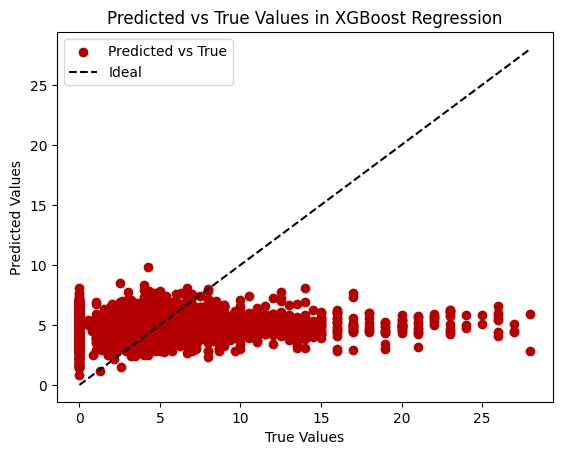

<Figure size 640x480 with 0 Axes>

In [108]:
plt.scatter(test_y, pred, color='#b30000', label='Predicted vs True')
plt.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], color='black', linestyle='--', label='Ideal')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs True Values in XGBoost Regression')
plt.legend()
plt.show()
## save to jpg
plt.savefig('Predicted vs True Values in XBBoost Regression.jpg')

In [116]:
### Baseline Naive model
# Baseline model
# Baseline model is the model that predicts the most frequent class from the training data
from sklearn.dummy import DummyRegressor
start_time = time.time()
baseline = DummyRegressor(strategy='mean').fit(train_X, train_y)
pred_y = baseline.predict(test_X)
end_time = time.time()
diff = end_time - start_time
results(test_y, pred_y,diff)

RMSE :  3.353835
MAE :  2.257430
MAPE :  1855941302962845.500000
R2 : -0.000010
Time Taken to Run the Model :  4.866489


In [117]:
# Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
start_time = time.time()
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(train_X, train_y)
pred_y = rf.predict(test_X)
end_time = time.time()
diff = end_time - start_time
results(test_y, pred_y,diff)

RMSE :  3.342827
MAE :  2.230132
MAPE :  1615799478912749.750000
R2 :  0.006544
Time Taken to Run the Model :  5.031872
